<a href="https://colab.research.google.com/github/MicroprocessorX069/Comparison-of-DC-GANS-and-SA-GANS/blob/master/CIFAR_10_DC_Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch 
import torchvision
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import os
from PIL import Image
import glob
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
import random
from bokeh.io import curdoc, show, output_notebook
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from functools import partial
from threading import Thread
from tornado import gen
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [0]:
#visualization
output_notebook()

#parameters
batch_size=10
train_split=0.85
num_epochs=50

#input
data_dir="data"
inp_width=32
inp_height=32
inp_channels=3

#generator
ngf=2
ndf=2

#discriminator
ndf=2

##Dataloader for CIFAR 10

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_size=int(train_split*len(dataset))
val_size=len(dataset)-train_size
trainset, valset=torch.utils.data.random_split(dataset,[train_size,val_size])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


##Preview of the dataset

Size of train set 10625
Size of val set 1875
Size of test set 2500


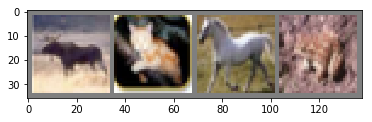

 deer   cat horse  frog
Size of images torch.Size([4, 3, 32, 32])


In [10]:
print("Size of train set",len(trainloader))
print("Size of val set",len(valloader))
print("Size of test set",len(testloader))



# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
print("Size of images",images.size())


##Functions and classes

In [0]:
# Classes and function definitions

class localImageDataset(torch.utils.data.Dataset):
  def __init__(self,data_dir,inp_width, inp_height, inp_channels):
    #Image list in the folder data
    self.data_dir=data_dir
    self.inp_width=inp_width
    self.inp_height=inp_height
    self.inp_channels=inp_channels
    
    self.image_list = []
    for filename in glob.glob('data/*.jpg'):
        self.image_list.append(filename)
        
    #image transformations from 1920x1280 to 240x160
    self.data_transform=transforms.Compose([
        transforms.Resize(size=160, interpolation=2),
        transforms.RandomResizedCrop((160,240)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.486,0.406],[0.229,0.224,0.225])
    ])
    
  def __getitem__(self,index):
    
    #reading the images nad label as filenames
    image=Image.open(self.image_list[index])
    label=os.path.splitext(self.image_list[index])[0][5:]
    
    #Synthetic paired image
    font = ImageFont.load_default().font
    font = ImageFont.truetype("C:/Windows/Fonts/ARLRDBD.ttf",190)
    img=Image.new("RGB", (self.inp_width,self.inp_height),(0,0,0))
    draw = ImageDraw.Draw(img)
    text_strtPt=(random.randint(300,500),random.randint(500,750))
    draw.text(text_strtPt,label,(255,255,255),font=font)
    draw = ImageDraw.Draw(img)
    
    #Transforming the data
    image=self.data_transform(image)
    syn_image=self.data_transform(img)
    
    #print(image.size)
    #returning a data pair ( image,label)
    return image,syn_image

  def __len__(self):
    return len(self.image_list)
  
class DiscriminatorGan(torch.nn.Module):
  def __init__(self,ndf,inp_channels):
    super(DiscriminatorGan,self).__init__()
    self.ndf=ndf
    self.inp_channels=inp_channels
    #input: 240x160x3
    self.layer1 = nn.Sequential(
            nn.Conv2d(self.inp_channels, ndf, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2))
    
            #120x80xndf    
            nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2,inplace=True),

            #60x40xndf*2
            nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2,inplace=True),

            #30x20xndf*4
            nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2,inplace=True)

            #15*10*ndf*8
    )
    
    n_features = 15*10*ndf*8
    n_out=1
    
    #Making the model
    #Sequential hidden layer: input nodes: n_features, output nodes: 1024, activation function: LeakyuRelu
    
    self.hidden0= nn.Sequential(nn.Linear(n_features,1024),nn.LeakyReLU(0.2),nn.Dropout(0.3))
    # nn.Dropout(probability) introduces random zeros to prevent overfitting, i.e. regularizing and preventing the coadapting of neurals.
    #probability is the probability than an element becomees 0
    
    #nn.LeakyRelU(negative_slope) leakyrelu(x)=max(0,x)+negative_slopt*min(0,x)
    self.hidden1=nn.Sequential(nn.Linear(1024,512),nn.LeakyReLU(0.2),nn.Dropout(0.3))
    self.hidden2=nn.Sequential(nn.Linear(512,256),nn.LeakyReLU(0.2),nn.Dropout(0.3)) 
    self.out=nn.Sequential(torch.nn.Linear(256,n_out),torch.nn.Sigmoid()) 

  def forward(self,x):
    x=self.layer1(x)
    x = x.reshape(x.size(0), -1)
    x=self.hidden0(x)
    x=self.hidden1(x)
    x=self.hidden2(x)
    x=self.out(x)
    return x

class GeneratorGan(torch.nn.Module):
  def __init__(self,ndf, ngf, out_channels):
    super(GeneratorGan,self).__init__() # Why is a super constructor created?
    self.ndf=ndf
    self.ngf=ngf
    self.out_channels=out_channels
    self.convLayers= nn.Sequential(
        #input: 240x160x3
        nn.Conv2d(3, ndf, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),

        #120x80xndf    
        nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2,inplace=True),

        #60x40xndf*2
        nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.2,inplace=True),

        #30x20xndf*4
        nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.2,inplace=True)
        #15*10*ndf*8
    )
    
    
    n_features = 15*10*ndf*8
    n_out=15*10*ngf*8 # flattened output image   
    
    self.hidden0=nn.Sequential(nn.Linear(n_features,1024),nn.LeakyReLU(0.2)) 
    self.hidden1=nn.Sequential(nn.Linear(1024,512),nn.LeakyReLU(0.2))
    self.hidden2=nn.Sequential(nn.Linear(512,256),nn.LeakyReLU(0.2))
    self.out=nn.Sequential(nn.Linear(256,n_out),nn.Tanh())  
    
    self.ConvTransLayers=nn.Sequential(

        # state size. 15x10x(ngf*8) 
        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),
        #(ngf*4) x 30 x 20
        nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),
        # (ngf*2) x 60 x 40
        nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        # s(ngf) x 120 x 80 
        nn.ConvTranspose2d(    ngf,      self.out_channels, 4, 2, 1, bias=False),
        # 3x240x160    
        nn.Tanh()
    )
    
  def forward(self,x):
    x=self.convLayers(x)
    x = x.reshape(x.size(0), -1)
    x=self.hidden0(x)
    x=self.hidden1(x)
    x=self.hidden2(x)
    x=self.out(x)
    x=x.reshape(x.size(0),self.ngf*8,10,15)
    x=self.ConvTransLayers(x)
    return x

def ones_target(size):
  #returning tensor variable containing ones, with shape =size
  data=Variable(torch.ones(size,1))
  return data

def zeros_target(size):
  data=Variable(torch.zeros(size,1))
  return data

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
def train_generator(optimizer, fake_data):
  N=fake_data.size(0)
  optimizer.zero_grad() #zero out the parameters of optimizer, because there are the no weights.
  #generating fake data by noise
  prediction=discriminator(fake_data)
  
  error=loss(prediction,ones_target(N))
  error.backward()
  optimizer.step()
  return error

#Here optimizer is adam optim. created above, as d_optimizer or g_optimizer
def train_discriminator(optimizer, real_data, fake_data):
    #init
  N=real_data.size(0)
  optimizer.zero_grad()
  
  #training on real_data
  prediction_real=discriminator(real_data)
  error_real=loss(prediction_real,ones_target(N))
  error_real.backward()
  rounded=torch.round(prediction_real)
  rounded=rounded.reshape(rounded.size(0)).detach().numpy()
  real_acc=np.count_nonzero(rounded)*100/rounded.size
  
    
  #training on fake dat
  prediction_fake=discriminator(fake_data)
  error_fake=loss(prediction_fake,zeros_target(N))
  error_fake.backward()
  rounded=torch.round(prediction_fake)
  rounded=rounded.reshape(rounded.size(0)).detach().numpy()
  fake_acc=np.count_nonzero(rounded==0)*100/rounded.size
  
  #updating weights and grad
  optimizer.step()
  return error_real+ error_fake, prediction_real, prediction_fake, real_acc, fake_acc
  

In [0]:
#Data loaders init
dataset=localImageDataset("data", inp_width, inp_height, inp_channels)

train_size=int(train_split*len(dataset))
val_size=len(dataset)-train_size
train_dataset, val_dataset=torch.utils.data.random_split(dataset,[train_size,val_size])
train_dataloader=torch.utils.data.DataLoader(dataset=train_dataset,
                                             batch_size=batch_size,
                                             shuffle=True)
num_batches=len(train_dataloader)
val_dataloader=torch.utils.data.DataLoader(dataset=val_dataset,
                                             batch_size=batch_size,
                                             shuffle=True)

In [0]:
from PIL import Image
import time
import numpy as np
from bokeh.models.sources import ColumnDataSource
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook

output_notebook()
loss_plot = figure(plot_width=800, plot_height=400)
test_data = ColumnDataSource(data=dict(x=[0], y=[0],z=[0]))
line = loss_plot.line("x", "y", source=test_data, alpha =0.5,color='green',
                     line_width=2, legend='Discriminator loss')
line = loss_plot.line("x", "z", source=test_data,alpha =1, color='red',
                     line_width=2, legend='Generator loss')
handle = show(loss_plot, notebook_handle=True)

new_data=dict(x=[0], y=[0],z=[0])

In [0]:
# models init
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
discriminator=DiscriminatorGan(ndf=ndf,inp_channels=inp_channels).to(device)
generator=GeneratorGan(ndf=2,ngf=2,out_channels=3).to(device)
d_optimizer=optim.Adam(discriminator.parameters(),lr=0.0002)
g_optimizer=optim.Adam(generator.parameters(),lr=0.0002)
loss=nn.BCELoss()

##Training the Gan

In [0]:
num_batches = len(train_dataloader)
for epoch in range(num_epochs):
  for n_batch,(real_batch,syn_batch) in enumerate(train_dataloader):
    N=real_batch.size(0)
    
    #Train discriminator
    real_data=real_batch
    real_data=real_data.to(device)
    #generating fake images and detach to avoid further calculation of gradients
    fake_data=generator(syn_batch).detach()
    fake_data=fake_data.to(device)
    #train
    d_error,d_pred_real,d_pred_fake, real_acc, fake_acc=train_discriminator(d_optimizer, real_data, fake_data)
    
    #Train Generator
    
    #generate fake data
    fake_data=generator(syn_batch)
    #train 
    g_error=train_generator(g_optimizer, fake_data)
         
    if(n_batch)%100==0: #??
      test_images=generator(syn_batch[0:4])
      test_images=test_images.data
            
      #display status logs
      #print("-----------------------------------------------------")
      #print("Epoch # %d/%d : Discrim err: %f; Genert err: %f" %(epoch, num_epochs,d_error, g_error))
      #print("Discriminator : real acc: %f; fake err: %f" %(real_acc, fake_acc))
#       import matplotlib.pyplot as plt
#       f, axarr = plt.subplots(2, 2)
#       axarr[0, 0].imshow(test_images[0,0])
#       axarr[0,1].imshow(test_images[1,0])
#       axarr[1, 0].imshow(test_images[2,0])
#       axarr[1, 1].imshow(test_images[3,0])
#       # Fine-tune figure; make subplots farther from each other.
#       f.subplots_adjust(hspace=0.3)
      #Real time plotting
      #x.append(epoch)
      #y.append(float(d_error))
      new_data['x'] = [epoch]  # prevent filling ram
      new_data['y'] = [float(d_error)]
      new_data['z'] = [float(g_error)]
    
      test_data.stream(new_data)
      push_notebook(handle=handle)
      #time.sleep(period)  
      #show(plot)
    
      #plt.show()

Loading BokehJS ...

In [0]:
show(plot)
# import matplotlib.pyplot as plt
# f, axarr = plt.subplots(2, 2)
# axarr[0, 0].imshow(test_images[0,0])
# axarr[0,1].imshow(test_images[1,0])
# axarr[1, 0].imshow(test_images[2,0])
# axarr[1, 1].imshow(test_images[3,0])
# # Fine-tune figure; make subplots farther from each other.
# f.subplots_adjust(hspace=0.3)

# plt.show()


https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f